<a href="https://colab.research.google.com/github/brentkendrick/HPLC-Data-Analysis/blob/master/HPLC%20data%20normalization%20and%20curve%20fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
%pip install peakutils

In [0]:
# import modules
import pandas as pd
import numpy as np

import os
import math
import warnings

from scipy import integrate

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.io as pio

import peakutils
from peakutils.plot import plot as pplot
from matplotlib import pyplot
%matplotlib inline


# Figure plot methods

In [0]:
# Method to define plotly.graph_objects plotting format
def go_layout(left=False,right=False,min_y=0,max_y=100):
    layout = Layout(width=1200, height=800,
                paper_bgcolor='white',
                plot_bgcolor='white',
                xaxis = {'showgrid': False, 
                         'showline': True, 
                         'linewidth':2, 
                         'linecolor':'black', 
                         'mirror':True,
                          'title_text':'RT (min)',
                          'range':[left, right],
                          'ticks':"outside", 'tickcolor':'black',
                          'tickwidth':2, 'ticklen':10},
                yaxis = {'showgrid': False, 
                         'showline': True, 
                         'linewidth':2, 
                         'linecolor':'black', 
                         'mirror':True,
                          'title_text': 'Abs',
                          'range':[min_y, max_y],
                          'ticks':"outside", 'tickcolor':'black',
                          'tickwidth':2, 'ticklen':10})
    return layout

In [0]:
def inset_plot(df, ylim=100, x1=20,x2=30,y1=0,y2=17):
    fig = plt.figure()

    ax1_shape = [0.1, 0.8, 2, 0.8] #lt edge, top edge, w, h
    ax1 = fig.add_axes(ax1_shape, ylim=(0,ylim))

    locs, labels = plt.xticks()  # Get the current locations and labels.
    plt.xticks(np.arange(0, 60, step=5))  # Set label locations.

    for i in range(len(df.columns)-1):
        ax1.plot(df['RT(min)'],df.iloc[:,(i+1)],label='rep'+ str(i+1))

    legend = ax1.legend(loc='best', shadow=True, fontsize='medium')    


    ax1_inset_shape = [0.5, 0.5, 0.4, 0.8] #lt edge, top edge, frac (w, h)
    axins = ax1.inset_axes(ax1_inset_shape)

    for i in range(len(df.columns)-1):
        axins.plot(df['RT(min)'],df.iloc[:,(i+1)],label='rep'+ str(i+1))

    x1, x2, y1, y2 = x1, x2, y1, y2 # sub region of the original image

    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    # axins.set_xticklabels('')
#     axins.set_yticklabels('')

    ax1.indicate_inset_zoom(axins)

    # plt.savefig('plot3.png', dpi=300, bbox_inches='tight')

    plt.show()
    
    return

In [0]:
def inset_plot_zoom2_stacked(df, offint=0.3, ylim=100, x1=20,x2=30,y1=0,y2=4):
    fig = plt.figure()

    ax1_shape = [0.1, 0.8, 2, 0.8] #lt edge, top edge, w, h
    ax1 = fig.add_axes(ax1_shape, ylim=(0,ylim))

    locs, labels = plt.xticks()  # Get the current locations and labels.
    plt.xticks(np.arange(0, 60, step=5))  # Set label locations.

    offset = 0
    for i in range(len(df.columns)-1):
        ax1.plot(df['RT(min)'],(df.iloc[:,(i+1)]+offset),label='rep'+ str(i+1))
        offset += offint

    legend = ax1.legend(loc='best', shadow=True, fontsize='medium')    


    ax1_inset_shape = [0.5, 0.5, 0.4, 0.8] #lt edge, top edge, frac (w, h)
    axins = ax1.inset_axes(ax1_inset_shape)

    offset = 0
    for i in range(len(df.columns)-1):
        axins.plot(df['RT(min)'],(df.iloc[:,(i+1)]+offset),label='rep'+ str(i+1))
        offset += offint

    x1, x2, y1, y2 = x1, x2, y1, y2 # sub region of the original image


    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    # axins.set_xticklabels('')
    # axins.set_yticklabels('')

    ax1.indicate_inset_zoom(axins)

#     plt.savefig('plot4.png', dpi=300, bbox_inches='tight')

    plt.show()
    
    return

# Code start

In [0]:
fileURL = 'https://github.com/brentkendrick/Public-HPLC-files/raw/master/ExampleData_HMQual.xlsx'


df1colnames=['RT(min)','rep1','rep2','rep3','rep4']
df1 = pd.read_excel(fileURL, 'testdata', header=None, names=df1colnames)



# df1 = pd.read_excel(fileURL, 'DS reps 1.5uL', header=None, names=df1colnames)
# df2 = pd.read_excel(fileURL, 'Load linearity')

# df1

In [0]:
df1.dropna(inplace=True)
# df1.tail()

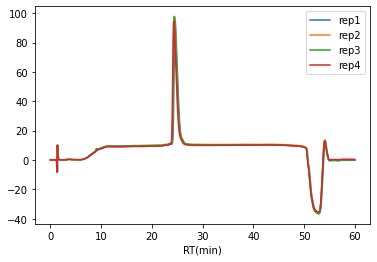

In [108]:
# gca stands for 'get current axis'
ax = plt.gca()

df1.plot(kind='line',x=df1colnames[0],y=df1colnames[1:7],ax=ax)

# Create interactive graph to interrogate region of interest

In [109]:
# Create interactive graph of cgms

# Call graph objects (go) cgm layout 
layout = go_layout(0, 60, min_y=-40, max_y=100)

# Call graph object figure initialization
fig = go.Figure(layout=layout)
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
# Add traces
for i in range(len(df1.columns)-1):

    fig.add_trace(go.Scatter(x = df1['RT(min)'], 
                             y = df1.iloc[:,(i+1)],
                             mode='lines',
                             name=df1.columns[(i+1)]))

pio.show(fig)    

In [0]:
# Truncate dataframe to region of interest

df_trnc = df1.copy()
left_cut = 13
right_cut = 45
filt = ((df_trnc['RT(min)']> left_cut) & 
        (df_trnc['RT(min)']< right_cut))#assign to variable

df_trnc = df_trnc.loc[filt] 

# x_val = df_trnc.iloc[:,0]
# y_val = df_trnc.iloc[:,1]

# Raw chromatograms

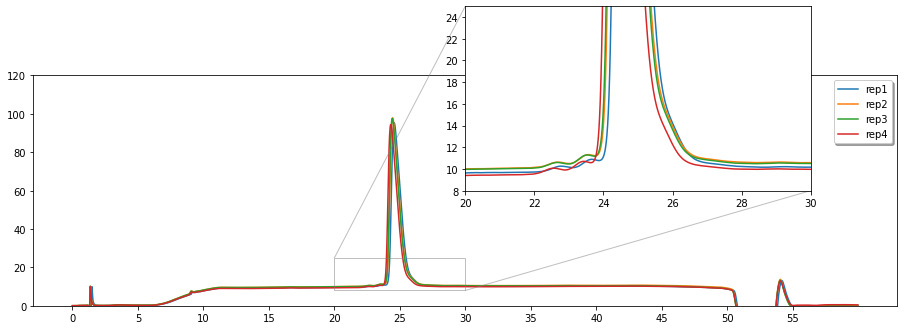

In [111]:
inset_plot(df1,ylim = 120, x1=20,x2=30,y1=8,y2=25)

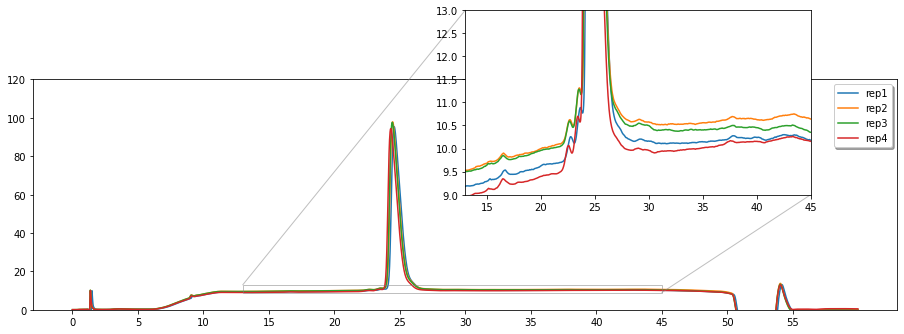

In [112]:
inset_plot_zoom2_stacked(df1, offint=0.0, ylim=120, x1=left_cut, x2=right_cut, y1=9, y2=13)

# Baseline correction algorithm 1
based on Eilers Asymmetric Least Squares Smoothing

There are two parameters: p for asymmetry and λ for smoothness. Both have to be tuned to the data at hand. 
For chemstation chromatograms, generally 1.0e-9 ≤ p ≤ 100.0e-9 is a good choice (for a signal with positive peaks) and 1.0e4 ≤ λ ≤ 100.0e4, but exceptions may occur. In any case one should vary λ on a grid that is approximately linear for log λ. Often visual inspection is sufficient to get good parameter values.

reference: https://stackoverflow.com/questions/29156532/python-baseline-correction-library/29185844


In [0]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z


In [0]:

lam = 40.0e4 # larger than 5e6 causes concave down curvature, smaller causes upward
p = 30.0e-9 # larger than 10e-9 flattens bl around large peaks, smaller no impact

x_val = df_trnc.iloc[:,0]
y_val = df_trnc.iloc[:,2]


base2=baseline_als_optimized(y_val, lam, p, niter=100)

In [115]:
# Call graph objects (go) cgm layout 
layout = go_layout(left_cut, right_cut, min_y=-1, max_y=10)

# Call graph object figure initialization
fig = go.Figure(layout=layout)

# Add traces
fig.add_trace(go.Scatter(x = x_val, y=(y_val - base2),
                    mode='lines',
                    name='baseline corrected ref1'))
fig.add_trace(go.Scatter(x = x_val, y=y_val-8.7,
                    mode='lines',
                    name='ref1'))
fig.add_trace(go.Scatter(x = x_val, y=base2-8.7,
                    mode='lines',
                    name='baseline'))

pio.show(fig)    

In [0]:
# Iterate through all data

lam = 40.0e4 # larger than 5e6 causes concave down curvature, smaller causes upward
p = 30.0e-9 # larger than 10e-9 flattens bl around large peaks, smaller no impact

corr_df1 = pd.DataFrame(columns=df1.columns)

for i in range(len(df1.columns)-1):

    x_val = df_trnc.iloc[:,0]
    y_val = df_trnc.iloc[:,(i+1)]

    base = baseline_als_optimized(y_val, lam, p, niter=100)
    
    corr_df1.iloc[:,0] = x_val
    
    corr_df1.iloc[:,(i+1)] = y_val-base

corr_df1.reset_index(drop=True, inplace=True)

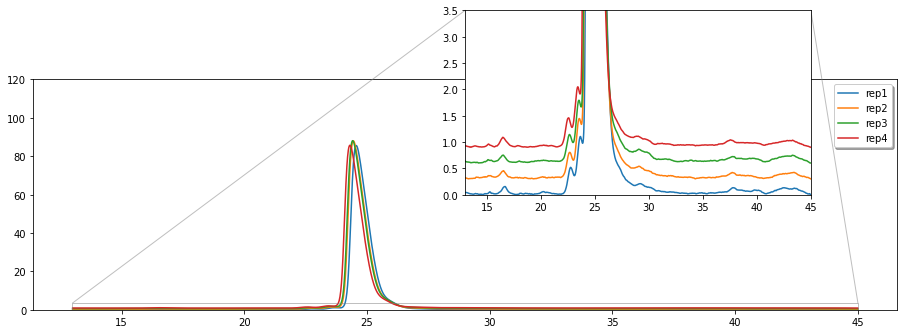

In [117]:
inset_plot_zoom2_stacked(corr_df1, offint=0.3, ylim=120, x1=left_cut, x2=right_cut, y1=0, y2=3.5)

# Peak centering

In [118]:
x_val = np.asarray(corr_df1.iloc[:,0])
y_val = np.asarray(corr_df1.iloc[:,1])

# find peak center X, and Y values
indexes = peakutils.indexes(y_val, thres=.35, min_dist=1)
print(indexes)
print(x_val[indexes], y_val[indexes])

# Alternate method: Fit peak to Gaussian and find center
peaks_x = peakutils.interpolate(x_val, y_val, ind=indexes)
print(peaks_x)

[1190]
[24.55833819] [85.55690418]
[24.56915382]


In [119]:
#(Note: peak is skewed, non-Gaussian, just use raw peak max for center

# Call graph objects (go) cgm layout 
layout = go_layout(left_cut, right_cut, min_y=-1, max_y=100)

# Call graph object figure initialization
fig = go.Figure(layout=layout)

# Add traces
fig.add_trace(go.Scatter(x = x_val, y=(y_val),
                    mode='lines',
                    name='baseline corrected ref1'))
fig.add_trace(go.Scatter(x = x_val[indexes], y= y_val[indexes],
                    mode='markers',
                    marker={'size':8, 'color':'#EB55BF'}))
                         
fig.add_trace(go.Scatter(x = peaks_x, y= y_val[indexes],
                    mode='markers',
                    marker={'size':8, 'color':'black'}))

pio.show(fig)    

In [120]:
# Find maximum peak center X, and Y values for every data column

x_val = np.asarray(corr_df1.iloc[:,0])
xctrs = []
yctrs = []

for i in range(len(corr_df1.columns)-1):
    y_val = np.asarray(corr_df1.iloc[:,(i+1)])

    indexes = peakutils.indexes(y_val, thres=.35, min_dist=1)
    xctrs.append(x_val[indexes][0].tolist())
    yctrs.append(y_val[indexes][0].tolist())

print(xctrs, yctrs)

[24.5583381867599, 24.4418559503009, 24.4127353911862, 24.3059600077655] [85.5569041769003, 87.66811494605678, 87.47179192830866, 84.79179417246998]


In [121]:
corr_df1.head()

RT(min)      rep1      rep2      rep3      rep4
0  13.007183  0.038293  0.017382  0.033361  0.024573
1  13.016890  0.037306  0.017763  0.032669  0.025053
2  13.026597  0.036619  0.017961  0.031916  0.025533
3  13.036304  0.036291  0.018221  0.030979  0.025895
4  13.046010  0.036622  0.017869  0.030104  0.026080

In [122]:
RTdelta = (corr_df1.loc[1, 'RT(min)'] - corr_df1.loc[0, 'RT(min)']) # retention time data interval
RTdelta

0.009706853038300878

In [0]:
# Shift the x-axis of the data to align to max peak

for i in range(len(corr_df1.columns)-2):
    shft = (int(round((xctrs[i+1]-xctrs[0])/RTdelta)))  #calculate the integer rows to shift data relative to 1st sample
    corr_df1.iloc[:,(i+2)]=corr_df1.iloc[:,(i+2)].shift(-shft)
# corr_df1.tail()

In [124]:
# Fill in ends of data after dataframe shift
corr_df1.ffill(axis = 0, inplace=True) 
corr_df1.bfill(axis = 0, inplace=True) 

corr_df1

RT(min)      rep1      rep2      rep3      rep4
0     13.007183  0.038293  0.017382  0.033361  0.024573
1     13.016890  0.037306  0.017382  0.033361  0.024573
2     13.026597  0.036619  0.017382  0.033361  0.024573
3     13.036304  0.036291  0.017382  0.033361  0.024573
4     13.046010  0.036622  0.017382  0.033361  0.024573
...         ...       ...       ...       ...       ...
3291  44.952436  0.004814  0.015938  0.018173  0.021895
3292  44.962143  0.003411  0.015010  0.016335  0.021802
3293  44.971850  0.002248  0.013838  0.014740  0.021533
3294  44.981557  0.001145  0.012544  0.013145  0.020909
3295  44.991264 -0.000079  0.011310  0.011612  0.020049

[3296 rows x 5 columns]

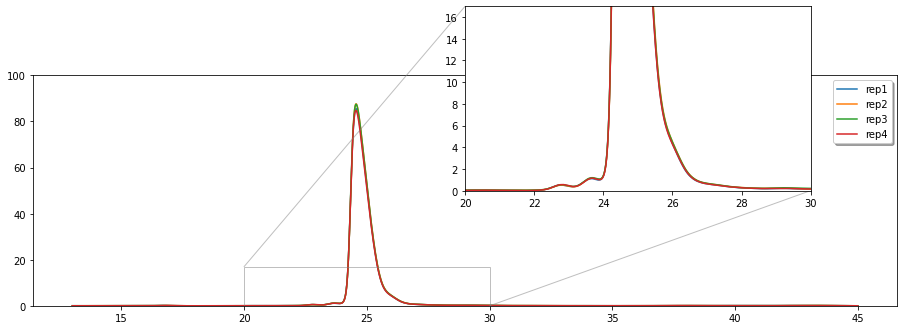

In [125]:
inset_plot(corr_df1,ylim = 100, x1=20,x2=30,y1=0,y2=17)

# Area normalize the data

In [0]:
def area_norm(df):
    """Normalize to area of 100"""

    proteins = list(df.columns)[1:]

    for i in proteins:
        dy = integrate.trapz(df[i], df[df.columns[0]]) 
        df[i] = df[i]/abs(dy)*100 #absolute value because decreasing x-values give negative area
    return df

In [127]:
area_norm_df = corr_df1.copy()
area_norm_df.reset_index(drop=True,inplace=True)
area_norm_df = area_norm(area_norm_df)
area_norm_df

RT(min)      rep1      rep2      rep3      rep4
0     13.007183  0.050408  0.022377  0.042848  0.032623
1     13.016890  0.049109  0.022377  0.042848  0.032623
2     13.026597  0.048205  0.022377  0.042848  0.032623
3     13.036304  0.047773  0.022377  0.042848  0.032623
4     13.046010  0.048209  0.022377  0.042848  0.032623
...         ...       ...       ...       ...       ...
3291  44.952436  0.006338  0.020519  0.023341  0.029067
3292  44.962143  0.004491  0.019325  0.020980  0.028944
3293  44.971850  0.002959  0.017815  0.018932  0.028586
3294  44.981557  0.001507  0.016149  0.016884  0.027758
3295  44.991264 -0.000104  0.014561  0.014914  0.026617

[3296 rows x 5 columns]

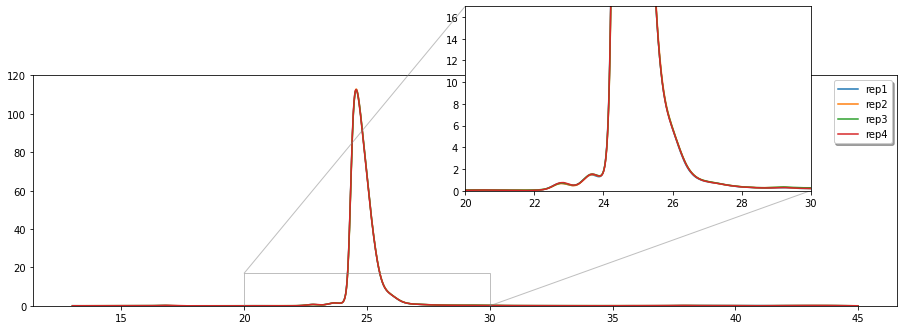

In [128]:
inset_plot(area_norm_df,ylim = 120, x1=20,x2=30,y1=0,y2=17)

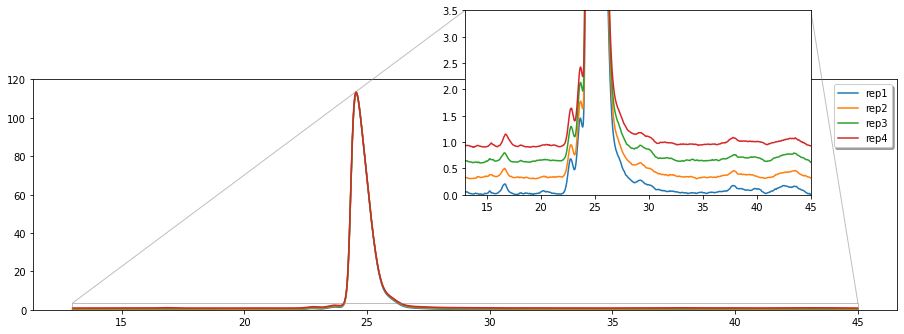

In [129]:
inset_plot_zoom2_stacked(area_norm_df, offint=0.3, ylim=120, x1=left_cut, x2=right_cut, y1=0, y2=3.5)

# Peak fitting algorithm
develop curve-fitting algorithm to fit peaks to a function, which will enable peak area calculations and additional chromatogram normalization processes

In [130]:
c_df = area_norm_df.copy()
c_df

RT(min)      rep1      rep2      rep3      rep4
0     13.007183  0.050408  0.022377  0.042848  0.032623
1     13.016890  0.049109  0.022377  0.042848  0.032623
2     13.026597  0.048205  0.022377  0.042848  0.032623
3     13.036304  0.047773  0.022377  0.042848  0.032623
4     13.046010  0.048209  0.022377  0.042848  0.032623
...         ...       ...       ...       ...       ...
3291  44.952436  0.006338  0.020519  0.023341  0.029067
3292  44.962143  0.004491  0.019325  0.020980  0.028944
3293  44.971850  0.002959  0.017815  0.018932  0.028586
3294  44.981557  0.001507  0.016149  0.016884  0.027758
3295  44.991264 -0.000104  0.014561  0.014914  0.026617

[3296 rows x 5 columns]

### Select peak for curve fitting

In [0]:
x = np.asarray(c_df.iloc[:,0])
y = np.asarray(c_df.iloc[:,1])

In [132]:
#scipy signal processing just uses 1-D arrays of y-data, assumes equal integer x-spacing
#create x data for signal processing
x_mod = np.arange(0,len(x))
x_mod

array([   0,    1,    2, ..., 3293, 3294, 3295])

In [133]:
# Conversion factor for peak array x-indices to retention time units
x_to_index_ratio = (x[-1] - x[0])/len(x)
x_to_index_ratio

0.009703907997881463

In [0]:
def find_peaks(x, y, idx_conv, height=None, threshold=None, distance=1, prominence = None, width=None):
    ''' 
    Find peak positions (returns array of peak indices, which can be converted to x-values by x[pk_idx])
    
    height:     Required height of peaks.
    threshold:  Vertical distance of peak to its neighbouring samples
    distance:   Required minimal horizontal distance (>= 1) in samples between neighbouring peaks. 
                Smaller peaks are removed first until the condition is fulfilled for all remaining peaks.
    prominance: The prominence of a peak measures how much a peak stands out from the surrounding baseline 
                of the signal and is defined as the vertical distance between the peak and its lowest contour line
    width:      Required width of peaks in samples
    '''
    
    from scipy.signal import chirp, find_peaks, peak_widths
    
    pk_idx, _ = find_peaks(y, height = height, threshold = threshold, 
                          distance = distance, prominence = prominence, width = width)
    
    # get y-value of each peak at the peak index
    h = y[pk_idx] 
    tR = x[pk_idx]
    
    '''return pk widths, height of base, left and right and positions as 
    interpolated indices at relative peak height'''
    full_width_idx, full_width_ht, full_L_pos_idx, full_R_pos_idx = peak_widths(y, pk_idx, rel_height = 1.0)  
    half_width_idx, half_width_ht, half_L_pos_idx, half_R_pos_idx = peak_widths(y, pk_idx, rel_height = 0.5)
    
    # Convert peak attributes from index values to original x-value units
    full_L_pos = full_L_pos_idx*idx_conv + x[0]
    full_R_pos = full_R_pos_idx*idx_conv + x[0]
    full_width = full_width_idx*idx_conv

    
    half_L_pos = half_L_pos_idx*idx_conv + x[0]
    half_R_pos = half_R_pos_idx*idx_conv + x[0]
    fwhm = half_width_idx*idx_conv
    
    # Call graph objects (go) cgm layout 
    layout = go_layout(x[1], x[-1], min_y=-1, max_y=120)

    # Call graph object figure initialization
    fig = go.Figure(layout=layout)

    # Add traces
    fig.add_trace(go.Scatter(x = x, y=y,
                        mode='lines',
                        name='baseline corrected ref1',
                        line=dict(
                            color='black',
                            width=1)))
    fig.add_trace(go.Scatter(x = x[pk_idx], y = y[pk_idx],
                        mode='markers',
                        name = 'local peak max',
                        marker_symbol='x-thin', marker_line_width=2, marker_color = 'red',marker_line_color="red",
                            marker_size=8))

    for i in range(len(full_L_pos)):

        fig.add_shape(
                # full peak width lines
                    type="line",
                    x0=full_L_pos[i],
                    y0=full_width_ht[i],
                    x1=full_R_pos[i],
                    y1=full_width_ht[i],
                    line=dict(
                        color="blue",
                        width=1,
                        dash=None,
                    ),
            )

        fig.add_shape(
                # half peak width lines
                    type="line",

                    x0=half_L_pos[i],
                    y0=half_width_ht[i],
                    x1=half_R_pos[i],
                    y1=half_width_ht[i],
                    line=dict(
                        color="red",
                        width=1,
                        dash=None,
                    ),name = 'half_peak_width'
            )


    pio.show(fig)      
    
    return pk_idx, h, fwhm, tR, half_L_pos, half_R_pos

In [135]:
pk_idx, h, fwhm, mu, pk_half_L, pk_half_R = find_peaks(x, y, x_to_index_ratio, height = 0.2, threshold = 0.00002, distance = 50, prominence = None, width = 10)

# Curve fit algorithms

# Models

### Standard Gaussian model (control model) 

The Gaussian peak takes the general form:  $y = he^{-\frac{1}{2}\left(\frac{(x-\mu)}{2\sigma}\right)^2}$

3 parameters: h, $\mu$, and $\sigma$


### Modified Haarhoff-van der Linde (HVL) model
Haarhoff, P. H., Van der Linde, H. J., Anal. Chem. 1966, 38, 573–582. and García-Alvarez-Coque et. al. Electrophoresis 2005, 26, 2076–2085  


$$y = h\frac{exp\left[-\frac{1}{2} \left(\frac{t-\mu}{\sigma}\right)^2\right]}
                                         {\left[exp\left(\frac{a\mu}{10^4a\sigma^2}\right)\right]^{-1} + 
                                         \frac{1}{2}\left[erf\left(\frac{t-\mu}{\sigma\sqrt2}\right)\right]}$$


4 parameters: h, $\mu$, $\sigma$, a (asym factor)  

Kendrick modifications: Since function was originally designed for triangular-Gaussian electrophoretic peak shapes...removed/replaced parameters that did not appreciably impact the overall fit, and modified asymmetry factor multiplication factor. 

### LMG Gaussian model

Linear modified gaussian, from J.Chrom.A. 2017, 1515, 129-137  

$$ y = he^{-\frac{1}{2}\frac{(t - \mu)^2}{(\sigma+b(t - \mu))^2}}$$

4 parameters: h, $\mu$, $\sigma$, b (asym factor) 

### Empirically transformed Gaussian (ETG) peak model

$$ y = \frac{h2}{\left[1 + {\lambda_L}e^{k_L(t_L - t)}\right]^{(t_L/t)^\alpha} +
                         \left[1 + {\lambda_T}e^{k_T(t - t_T)}\right]^{(t/t_T)^\beta} - 1}$$
where:
 - t is time
 - h2 is related to peak amplitude
 - ${\lambda_L}$ and ${\lambda_T}$ are pre-exponential parameters
 - ${k_L}$ and ${k_T}$ are parameters related to speed of rise and fall of leading and trailing edges, respectively
 - $\alpha$ and $\beta$ are parameters to further modify shapes of leading and trailing edges, respectively
 - $t_L$ and $t_T$ are x-positions of leading and trailing edges at fwhm
 
 J. Li, “Comparison of the capability of peak functions in describing real chromatographic peaks,” Journal of Chromatography A, vol. 952, no. 1–2, pp. 63–70, Apr. 2002

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import peakutils
from peakutils.plot import plot as pplot
import math

from scipy.special import erf
from scipy.special import erfc
from scipy.optimize import least_squares

from math import sqrt, pi, log
from numpy import exp, ravel

import requests

In [0]:
# Define empty functions to prevent peak method from failing before functions are called

def gaussian():
    pass

def HVL():
    pass

def ETG():
    pass

def LMG():
    pass

In [0]:
def component_pks(x, meth, *flat_params):  
    # function to create list of individual peak y-values, with flat list passed in for all parameters
    
    # function mapper, takes in string and maps it to known functions
    fun =  {
            'gaussian':gaussian,
            'HVL':HVL,
            'ETG':ETG,
            'LMG':LMG,       
           } 
    
    num_pks = int(len(pk_idx))
    num_fun_params = int(len(flat_params)/num_pks)
    
    # create empty array for y - data for all peaks
    out = np.zeros(int(len(x)*num_pks))
    out = np.split(out, num_pks)
    
    # create empty array for parameters for all peaks
    params = np.zeros(int(len(flat_params)*num_pks))
    params = np.split(params, num_pks)    
    
    j = 0           
    for i in range(num_pks):
        params = flat_params[j: (j + num_fun_params)]
        out[i] = fun[meth](x, *params)
        j += num_fun_params
    
    return out

In [0]:
pk_sum = lambda x, method, *params: sum(component_pks(x, method, *params)) # function to combine indiv peaks

In [0]:
residual = lambda p0, y, x, method: pk_sum(x, method, *p0) - y # residual (error) function for least_sq minimization

# Peak statistics

In [0]:
def peak_areas(x, peaklist):
    pk_area = []    
    for i in range(int(len(peaklist))):
        
        pk_area_tmp = np.trapz(peaklist[i], x) #integrates individual fitted peak
        pk_area.append(pk_area_tmp)#packs each peak area into a list
        
    pk_area_pct = []    
    for i in range(int(len(peaklist))):
        pk_area_pct_temp = pk_area[i]/(sum(pk_area))
        pk_area_pct.append(pk_area_pct_temp) 
                                       
        print ('Area {}  is {:1.2%} of the whole area'.format(str(i+1), pk_area[i]/(sum(pk_area))))

    return pk_area_pct

In [0]:
def wsd(y, y_fit):
    """Calculates the WSD for two samples"""
    n = int(len(y))
    y_avg = sum(y) / n
    wsd_sq = 0
    for i in range(n):
        wsd_sq = wsd_sq + (1 / n) * \
            (abs(y[i]) / abs(y_avg)) * ((y_fit[i]) - (y[i]))**2
    wsd = math.sqrt(wsd_sq)
    return wsd

In [0]:
def overlap(x, y, y_fit):
    """Calculates area of commonality / overlap"""

    y_fit_area = np.trapz(y_fit, x)  #integrate area of y_fit
    y_fit_norm = y_fit/y_fit_area  #area normalize to 1
    
    y_area = np.trapz(y, x)
    y_area_norm = y/y_area
    
    y_min = np.minimum(y_area_norm,y_fit_norm)  # finds stepwise minimum element of both datasets

    y_min_area = np.trapz(y_min, x) # get area of y_min
   
    return y_min_area

In [0]:
def R2(resid, y):
    return (1 - np.sum((resid ** 2))/np.sum((y - y.mean())**2))  #gives R-squared of fit

In [0]:
def dca(x, y, y_fit):
    """Calculates the derivative correlation algorithm (DCA) for two samples in the DataFrame"""
    n = int(len(y))
    p_sq = 0
    A = 0
    B = 0
    C = 0
    # create a list of n elements, all zero to make endpoints zero after loop below
    y_der = [0] * n
    y_fit_der = [0] * n

    for i in range(2, n - 1):  # want i = 1 and i = n elements equal to zero
        y_der[i] = (y[i + 1] - y[i - 1]) / 2
        y_fit_der[i] = (y_fit[i + 1] - y_fit[i - 1]) / 2

    for i in range(n):
        A = A + y_der[i] * y_fit_der[i]
        B = B + (y_der[i])**2
        C = C + (y_fit_der[i])**2

    p_sq = (A**2 / (B * C))
    p = math.sqrt(p_sq)
    DCA_value = (p**21 + p) / 2
    return DCA_value

# Abbreviations

Id  | Description 
--|:---------
x|source x-axis data            
mu or tR|$\mu$ mean (center) of peak (tR is peak retention time) 
s| $\sigma$, standard deviation, i.e. $\sqrt{variance}$, where variance isthe average of the squared differences of the x-values from the mean. 
y | source intensity (absorbance) axis data   
h | peak height(s)  
fwhm| peak full width at half maximum of peak height  
p0 | initial parameters for peak fitting  

# Peak models

In [0]:
def test_fit_fig(x, y, y_gaussian_p0):

    # Call graph objects (go) cgm layout 
    layout = go_layout(x[1], x[-1], min_y=-1, max_y=120)

    # Call graph object figure initialization
    fig = go.Figure(layout=layout)

    # Add traces
    fig.add_trace(go.Scatter(x = x, y=y,
                        mode='lines',
                        name='y-data',
                        line=dict(
                            color='black',
                            width=1)))
    fig.add_trace(go.Scatter(x = x, y=sum(y_gaussian_p0),
                        mode='lines',
                        name='Fitted y',
                        line=dict(
                            color='red',
                            width=1)))


    for i in range(len(y_gaussian_p0)):
        name = 'Peak{}'.format(str(i+1))

        fig.add_trace(go.Scatter(x = x, y=y_gaussian_p0[i],
                        mode='lines',
                        name=name,
                        line=dict(width=1)))

    pio.show(fig)      

# Standard Gaussian model

Standard peak relationships include:

$\sigma = \frac{fwhm}{2\sqrt{2ln2}} \approx$ 0.4247*fwhm

The Gaussian peak takes the general form:  $y = he^{-\frac{1}{2}\left(\frac{(x-\mu)}{2\sigma}\right)^2}$


<img src="https://upload.wikimedia.org/wikipedia/commons/7/74/Normal_Distribution_PDF.svg" width="400" height="200" />

In [0]:
def gaussian(x, h, mu, s):  
    return h*exp(-(x - mu)**2/(2*s**2)) #Function defining a gaussian distribution

In [0]:
s = fwhm/(2*sqrt(2*log(2))) # convert fwhm from peak detection method to sigma

In [149]:
gaussian_p0 = ravel(list(zip(h, mu, s))) # create 1-D list of all peak fitting parameters
count =0
for i in range(int(len(gaussian_p0)/3)):
    print ('\npk ht = {:.2f} AU'.format(gaussian_p0[count]))
    print ('pk ctr = {:.2f} min'.format(gaussian_p0[count+1]))
    print ('pk sigma = {:.2f} '.format(gaussian_p0[count+2]))
    count += 3

# gaussian_p0 = list(ravel([[p1, p2, p3] for (p1, p2, p3) in zip(h, s, mu)])) # initial curve fitting params


pk ht = 0.20 AU
pk ctr = 16.70 min
pk sigma = 0.24 

pk ht = 0.68 AU
pk ctr = 22.76 min
pk sigma = 0.14 

pk ht = 1.45 AU
pk ctr = 23.67 min
pk sigma = 0.08 

pk ht = 112.63 AU
pk ctr = 24.56 min
pk sigma = 0.33 

pk ht = 0.27 AU
pk ctr = 29.16 min
pk sigma = 0.20 


In [0]:
y_gaussian_p0 = component_pks(x, 'gaussian', *gaussian_p0) # list of individual optimized gaussian peaks

In [151]:
test_fit_fig(x, y, y_gaussian_p0)

In [152]:
# Create boundaries for curve fitting (need high (1st list) 
# and low (2nd list) values for every parameter in every peak)

h_low = [0.8*x for x in h]
h_high = [1.2*x for x in h]

mu_low = [x-0.1 for x in mu]
mu_high = [x+0.1 for x in mu]

s_low = [0.01 for x in s]
s_high = [1.0 for x in s]


bnd_low = []
bnd_high = []
for i in range(len(pk_idx)):
    bnd_low_temp = [h_low[i], mu_low[i], s_low[i]]
    bnd_high_temp = [h_high[i], mu_high[i], s_high[i]]
    bnd_low += bnd_low_temp
    bnd_high += bnd_high_temp
    
gaussian_bnds = (bnd_low,bnd_high)
gaussian_bnds

([0.1617591925040686,
  16.5957872257814,
  0.01,
  0.5446372089826541,
  22.6625703746846,
  0.01,
  1.1622820983173854,
  23.5653077072413,
  0.01,
  90.10109930080672,
  24.4583381867599,
  0.01,
  0.21810903302774567,
  29.059386526887998,
  0.01],
 [0.24263878875610287,
  16.795787225781403,
  1.0,
  0.8169558134739812,
  22.8625703746846,
  1.0,
  1.7434231474760782,
  23.765307707241302,
  1.0,
  135.15164895121006,
  24.658338186759902,
  1.0,
  0.32716354954161847,
  29.259386526888,
  1.0])

In [0]:
opt_gaussian = least_squares(residual, gaussian_p0, loss='linear', bounds=gaussian_bnds, args=(y, x, 'gaussian'))
gaussian_p, gaussian_resid = opt_gaussian.x, opt_gaussian.fun

In [0]:
opt_gauss_pks = component_pks(x, 'gaussian', *gaussian_p) # list of individual optimized gaussian peaks

In [155]:
opt_gauss_pk_areas = peak_areas(x, opt_gauss_pks)

Area 1  is 0.15% of the whole area
Area 2  is 0.62% of the whole area
Area 3  is 0.26% of the whole area
Area 4  is 98.06% of the whole area
Area 5  is 0.90% of the whole area


In [156]:
opt_gauss_pk_areas

[0.0015392514183779507,
 0.0062199122846141545,
 0.002559978480731254,
 0.9806369249105292,
 0.009043932905747567]

In [0]:
def fitted_peaks_fig(x, y, ind_pk_ys, ind_pk_area_pcts):

    # Call graph objects (go) cgm layout 
    layout = go_layout(x[1], x[-1], min_y=-1, max_y=120)

    # Call graph object figure initialization
    fig = go.Figure(layout=layout)

    # Add traces
    fig.add_trace(go.Scatter(x = x, y=y,
                        mode='lines',
                        name='y-data',
                        line=dict(
                            color='black',
                            width=1)))
    fig.add_trace(go.Scatter(x = x, y=sum(ind_pk_ys),
                        mode='lines',
                        name='Fitted y',
                        line=dict(
                            color='red',
                            width=1)))


    for i in range(len(ind_pk_ys)):
        name = 'Area {}  is {:1.2%} of the whole area'.format(str(i+1), ind_pk_area_pcts[i])

        fig.add_trace(go.Scatter(x = x, y=ind_pk_ys[i],
                        mode='lines',
                        name=name,
                        line=dict(width=1)))

    pio.show(fig)      

In [158]:
fitted_peaks_fig(x, y, opt_gauss_pks, opt_gauss_pk_areas)

In [159]:
R2_gaussian = R2(gaussian_resid, y)
R2_gaussian

0.9504602366041923

In [160]:
wsd_gaussian = wsd(y, sum(opt_gauss_pks))
wsd_gaussian

9.984858493307305

In [161]:
AOO_gaussian = overlap(x, y, sum(opt_gauss_pks))
AOO_gaussian

0.8479496700387728

In [162]:
dca_gaussian = dca(x, y, sum(opt_gauss_pks))
dca_gaussian

0.4497188145377552

# Haarhoff-van der Linde (HVL) model

$$y = \frac{hw}{at_R\sqrt{2\pi}} \frac{exp\left[-\frac{1}{2} \left(\frac{t-t_r}{w}\right)^2\right]}
                                         {\left[exp\left(\frac{at_R}{w^2}\right)-1\right]^{-1} + 
                                         \frac{1}{2}\left[1 + erf\left(\frac{t-t_R}{w\sqrt2}\right)\right]}$$

Good fit, but can be overly sensitive to parameter errors 
Since it combines Gaussian model a triangular function.  For asymmetrical peaks, the asymmetry factor 'a' influences the values of other parameters, making their interpretation difficult and requiring non-intuitive scaling factors to the initial parameters to enable a fit.  
from: Haarhoff, P. H., Van der Linde, H. J., Anal. Chem. 1966, 38, 573–582. and García-Alvarez-Coque et. al. Electrophoresis 2005, 26, 2076–2085



# Kendrick Mods to Haarhoff-van der Linde (HVL) model

$$y = h\frac{exp\left[-\frac{1}{2} \left(\frac{t-\mu}{\sigma}\right)^2\right]}
                                         {\left[exp\left(\frac{a\mu}{10^4a\sigma^2}\right)\right]^{-1} + 
                                         \frac{1}{2}\left[erf\left(\frac{t-\mu}{\sigma\sqrt2}\right)\right]}$$

Removed parameters that did not appreciably impact the overall fit, and modified asymmetry factor multiplication factor



In [0]:
def HVL(x, h, s, mu, a):
    return h * (exp(-1/2 * ((x-mu)/s)**2))/(1/(exp(a*mu/(1e4*s**2))) + 1/2 * (erf((x-mu)/(s*sqrt(2)))))  

In [0]:
a = 1 # Asymmetry factor has trouble fitting mix of asymmetric and symmetric peaks. 
          # Use approx 1 for highly symmetric peaks.  Stay between 0.1 a < 10 for triangular peaks.  

HVL_p0 = list(ravel([[p1, p2, p3, a] for (p1, p2, p3) in zip(h, s, mu)])) # initial curve fitting params

In [0]:
y_HVL_p0 = component_pks(x, 'HVL', *HVL_p0)

In [166]:
test_fit_fig(x, y, y_HVL_p0)

In [167]:
# Create boundaries for curve fitting (need high (1st list) 
# and low (2nd list) values for every parameter in every peak)

h_low = [0.2*x for x in h]
h_high = [2*x for x in h]

mu_low = [x-1 for x in mu]
mu_high = [x+2 for x in mu]

s_low = [0.01 for x in s]
s_high = [1.0 for x in s]


bnd_low = []
bnd_high = []
for i in range(len(pk_idx)):
    bnd_low_temp = [h_low[i], s_low[i], mu_low[i], 0.1]
    bnd_high_temp = [h_high[i], s_high[i], mu_high[i], 10]
    bnd_low += bnd_low_temp
    bnd_high += bnd_high_temp
    
HVL_bnds = (bnd_low,bnd_high)
HVL_bnds

([0.04043979812601715,
  0.01,
  15.695787225781402,
  0.1,
  0.13615930224566353,
  0.01,
  21.7625703746846,
  0.1,
  0.29057052457934635,
  0.01,
  22.6653077072413,
  0.1,
  22.52527482520168,
  0.01,
  23.5583381867599,
  0.1,
  0.05452725825693642,
  0.01,
  28.159386526888,
  0.1],
 [0.40439798126017146,
  1.0,
  18.6957872257814,
  10,
  1.3615930224566353,
  1.0,
  24.7625703746846,
  10,
  2.9057052457934636,
  1.0,
  25.6653077072413,
  10,
  225.2527482520168,
  1.0,
  26.5583381867599,
  10,
  0.5452725825693642,
  1.0,
  31.159386526888,
  10])

In [0]:
opt_HVL = least_squares(residual, HVL_p0, loss='linear', bounds=HVL_bnds, args=(y, x, 'HVL'))
HVL_p, HVL_resid = opt_HVL.x, opt_HVL.fun

In [0]:
opt_HVL_pks = component_pks(x, 'HVL', *HVL_p) # list of individual optimized gaussian peaks

In [170]:
opt_HVL_pk_areas = peak_areas(x, opt_HVL_pks)

Area 1  is 0.15% of the whole area
Area 2  is 0.57% of the whole area
Area 3  is 0.43% of the whole area
Area 4  is 97.19% of the whole area
Area 5  is 1.66% of the whole area


In [171]:
fitted_peaks_fig(x, y, opt_HVL_pks, opt_HVL_pk_areas)

In [172]:
R2_HVL = R2(HVL_resid, y)
R2_HVL

0.976176531907147

In [173]:
# LMG_fitted_y = LMG_pk_sum(t, *LMGguess)
wsd_HVL = wsd(y, sum(opt_HVL_pks))
wsd_HVL

8.714181287618668

In [174]:
AOO_HVL = overlap(x, y, sum(opt_HVL_pks))
AOO_HVL

0.8907530989371567

In [175]:
dca_HVL = dca(x, y, sum(opt_HVL_pks))
dca_HVL

0.49504524401033223

# Empirically transformed Gaussian (ETG) peak model

$$ y = \frac{h2}{\left[1 + {\lambda_L}e^{k_L(t_L - t)}\right]^{(t_L/t)^\alpha} +
                         \left[1 + {\lambda_T}e^{k_T(t - t_T)}\right]^{(t/t_T)^\beta} - 1}$$
where:
 - t is time
 - h2 is related to peak amplitude
 - ${\lambda_L}$ and ${\lambda_T}$ are pre-exponential parameters
 - ${k_L}$ and ${k_T}$ are parameters related to speed of rise and fall of leading and trailing edges, respectively
 - $\alpha$ and $\beta$ are parameters to further modify shapes of leading and trailing edges, respectively
 - $t_L$ and $t_T$ are x-positions of leading and trailing edges at fwhm
 
 J. Li, “Comparison of the capability of peak functions in describing real chromatographic peaks,” Journal of Chromatography A, vol. 952, no. 1–2, pp. 63–70, Apr. 2002


In [0]:
def ETG(x, h2, L, T, kL, kT, a, b, tL, tT):
    '''
    h: pk ht
    L, T: lambda left, lambda right pre-exponential intially set at 1 
        (seems to usually fit somewhere btwn 1 - 2, 
        L: higher number moves peak to right, decreases height, smaller slope, must be > 0)
        T: higher number moves peak to left, decreases height, smaller slope, must be > 0
    kL, kT: left, right edge rise: intially set at about 4 / fwhm:  i.e for fwhm = 0.1, set at 40
            lower number decreases peak slope (seems to usually be between 0.1/fwhm and 100/fwhm)
    a, b: leading, trailing edge shape, higher number gives higher slope at peak bottoms
            must be > 0.5 and <10  in most cases
    tL and tT are global variables from left and right sides of fwhm
    '''
    return h2/((1+L*exp(kL*(tL-x)))**(tL/x)**a + (1+T*exp(kT*(x-tT)))**(x/tT)**b - 1)

In [0]:
h2 = h*1.2 # need to usually adjust peak heights up a bit
L, T = 1, 1
kL, kT = 4/fwhm, 4/fwhm
a, b = 1, 1
tL, tT =  pk_half_L, pk_half_R  # set global tL and tT variables for ETG peak model based on peak characteristics

# This method of creating a flat p0 list makes it easy to iterate in the empirical parameters

ETG_p0 = list(ravel([[p1, L, T, p2, p3, a, b, p4, p5] for (p1, p2, p3, p4, p5) in zip(h2, kL, kT, tL, tT)])) # initial curve fitting params

In [178]:
y_ETG_p0 = component_pks(x, 'ETG', *ETG_p0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

overflow encountered in power



In [179]:
test_fit_fig(x, y, y_ETG_p0)

In [0]:
# Create boundaries for curve fitting (need high (1st list) 
# and low (2nd list) values for every parameter in every peak)

k_low = [0.1/x for x in fwhm]
k_high = [100/x for x in fwhm]

tL_low = [x-0.00001 for x in tL]
tL_high = [x+0.00001 for x in tL]
tT_low = [x-0.00001 for x in tT]
tT_high = [x+0.00001 for x in tT]

bnd_low = []
bnd_high = []
for i in range(len(pk_idx)):
    bnd_low_temp = [0, 0, 0, k_low[i], k_low[i], 0.5, 0.5, tL_low[i], tT_low[i]]
    bnd_high_temp = [1e9, 1e6, 1e6, k_high[i], k_high[i], 10, 10, tL_high[i], tT_high[i]]
    bnd_low += bnd_low_temp
    bnd_high += bnd_high_temp
    
bnds = (bnd_low,bnd_high)
# bnds

In [181]:
opt_ETG = least_squares(residual, ETG_p0, loss='linear', bounds=bnds, args=(y, x, 'ETG'))
ETG_p, ETG_resid = opt_ETG.x, opt_ETG.fun

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

overflow encountered in power

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

overflow encountered in multiply



In [182]:
opt_ETG_pks = component_pks(x, 'ETG', *ETG_p) # list of individual optimized gaussian peaks

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

overflow encountered in power



In [183]:
opt_ETG_pk_areas = peak_areas(x, opt_ETG_pks)

Area 1  is 0.15% of the whole area
Area 2  is 5.24% of the whole area
Area 3  is 2.28% of the whole area
Area 4  is 91.05% of the whole area
Area 5  is 1.28% of the whole area


In [184]:
fitted_peaks_fig(x, y, opt_ETG_pks, opt_ETG_pk_areas)

In [185]:
R2_ETG = R2(ETG_resid, y)
R2_ETG

0.9999345704693702

In [186]:
# LMG_fitted_y = LMG_pk_sum(t, *LMGguess)
wsd_ETG = wsd(y, sum(opt_ETG_pks))
wsd_ETG

0.4017600885958932

In [187]:
AOO_ETG = overlap(x, y, sum(opt_ETG_pks))
AOO_ETG

0.9896583729286085

In [188]:
dca_ETG = dca(x, y, sum(opt_ETG_pks))
dca_ETG

0.9934492566216582

# LMG Gaussian model

Linear modified gaussian, from J.Chrom.A. 2017, 1515, 129-137

In [0]:
def LMG(x, h, mu, s, b):
    from numpy import exp
     # h peak height
     # mu elution time
     # s std dev of symm peak that behaves as the asym peak near it's max
     # b peak asymmetry
    tc = x - mu
    return h*exp(-tc**2/2.0/(s-b*tc)**2)

In [0]:
b = -0.2 # Asymmetry factor
# This method of creating a flat p0 list makes it easy to iterate in the empirical parameters

LMG_p0 = list(ravel([[p1, p2, p3, b] for (p1, p2, p3) in zip(h, mu, s)])) # initial curve fitting params

In [191]:
LMG_p0

[0.20219899063008573,
 16.6957872257814,
 0.2432567832528138,
 -0.2,
 0.6807965112283176,
 22.7625703746846,
 0.13707651350220693,
 -0.2,
 1.4528526228967318,
 23.6653077072413,
 0.08490835286145207,
 -0.2,
 112.6263741260084,
 24.5583381867599,
 0.3260638992418009,
 -0.2,
 0.2726362912846821,
 29.159386526888,
 0.20116826500533858,
 -0.2]

In [0]:
y_LMG_p0 = component_pks(x, 'LMG', *LMG_p0)

In [193]:
test_fit_fig(x, y, y_LMG_p0)

In [194]:
# Create boundaries for curve fitting (need high (1st list) 
# and low (2nd list) values for every parameter in every peak)

h_low = [0.2*x for x in h]
h_high = [2*x for x in h]

mu_low = [x-1 for x in mu]
mu_high = [x+2 for x in mu]

s_low = [0.01 for x in s]
s_high = [1.0 for x in s]


bnd_low = []
bnd_high = []
for i in range(len(pk_idx)):
    bnd_low_temp = [h_low[i], mu_low[i], s_low[i], -1]
    bnd_high_temp = [h_high[i], mu_high[i], s_high[i], 10]
    bnd_low += bnd_low_temp
    bnd_high += bnd_high_temp
    
LMG_bnds = (bnd_low,bnd_high)
LMG_bnds

([0.04043979812601715,
  15.695787225781402,
  0.01,
  -1,
  0.13615930224566353,
  21.7625703746846,
  0.01,
  -1,
  0.29057052457934635,
  22.6653077072413,
  0.01,
  -1,
  22.52527482520168,
  23.5583381867599,
  0.01,
  -1,
  0.05452725825693642,
  28.159386526888,
  0.01,
  -1],
 [0.40439798126017146,
  18.6957872257814,
  1.0,
  10,
  1.3615930224566353,
  24.7625703746846,
  1.0,
  10,
  2.9057052457934636,
  25.6653077072413,
  1.0,
  10,
  225.2527482520168,
  26.5583381867599,
  1.0,
  10,
  0.5452725825693642,
  31.159386526888,
  1.0,
  10])

In [0]:
opt_LMG = least_squares(residual, LMG_p0, loss='linear', bounds=LMG_bnds, args=(y, x, 'LMG'))
LMG_p, LMG_resid = opt_LMG.x, opt_LMG.fun

In [0]:
opt_LMG_pks = component_pks(x, 'LMG', *LMG_p) # list of individual optimized gaussian peaks

In [197]:
opt_LMG_pk_areas = peak_areas(x, opt_LMG_pks)

Area 1  is 0.08% of the whole area
Area 2  is 0.24% of the whole area
Area 3  is 1.70% of the whole area
Area 4  is 97.11% of the whole area
Area 5  is 0.86% of the whole area


In [198]:
fitted_peaks_fig(x, y, opt_LMG_pks, opt_LMG_pk_areas)

In [199]:
R2_LMG = R2(LMG_resid, y)
R2_LMG

0.9979931183349038

In [200]:
# LMG_fitted_y = LMG_pk_sum(t, *LMGguess)
wsd_LMG = wsd(y, sum(opt_LMG_pks))
wsd_LMG

2.9139910174259307

In [201]:
AOO_LMG = overlap(x, y, sum(opt_LMG_pks))
AOO_LMG

0.9676638377491502

In [202]:
dca_LMG = dca(x, y, sum(opt_LMG_pks))
dca_LMG

0.8466395421344215

# Result Summary

Peak Model optimization summary

In [0]:
pk_fitted_ys = [opt_gauss_pks, opt_LMG_pks, opt_HVL_pks, opt_ETG_pks]

In [0]:
sum_pk_fitted_ys = [sum(opt_gauss_pks), sum(opt_LMG_pks), sum(opt_HVL_pks),
                   sum(opt_ETG_pks)]

In [0]:
pk_fitted_resids = [gaussian_resid, LMG_resid, HVL_resid, ETG_resid]

In [0]:
pk_R2s = [R2_gaussian, R2_LMG, R2_HVL,R2_ETG]

In [0]:
pk_AOOs = [AOO_gaussian, AOO_LMG, AOO_HVL, AOO_ETG]

In [0]:
pk_WSDs = [wsd_gaussian, wsd_LMG, wsd_HVL, wsd_ETG]

In [0]:
pk_DCAs = [dca_gaussian, dca_LMG, dca_HVL, dca_ETG]

In [0]:
pk_areas = [opt_gauss_pk_areas, opt_LMG_pk_areas, 
           opt_HVL_pk_areas, opt_ETG_pk_areas]

In [0]:
pk_labels = ['Gaussian Model', 'Linear Modified Gaussian Model', 
             'Haarhoff-van der Linde Model',
             'Empirically Transformed Gaussian Model']

In [0]:
def res_plots(x, y, fitted_y_sum, fitted_y, resids, R2, AOO, wsd, dca, pk_areas, labels):
    
    numrows = round(len(fitted_y)/2)
    numcols = 2
    figsize_width = 15*numcols
    figsize_height = 8*numrows
    fig, axs = plt.subplots(numrows, numcols, figsize=(figsize_width, figsize_height))

    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 20

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    def two_scales(ax1, time, data1, data2, data3, data4, label, c1, c2, c3):

        ax2 = ax1.twinx()

        ax1.plot(time, data1, color=c1)
        ax1.plot(time, data2, color=c2, linewidth=2)
        ax1.plot(time, data3[0], '--', linewidth=2, color = 'g')
        ax1.plot(time, data3[1], '--', linewidth=2,color = 'y')
        ax1.legend(['Chromatogram', 'Fitted Peak Sum', 'Fitted Peak 1', 'Fitted Peak 2'])
        ax1.set_xlabel('Retention time (m)')
        ax1.set_ylabel('chromatogram y', color='k')

        ax1.set_ylim(-30000,30000)
        ax1.set_title(label)

        ax2.plot(time, data4, color=c3)
        ax2.set_ylabel('residual y', color='k',rotation=270)
        ax2.set_ylim(-8000, 15000)
        ax2.legend(['residual'],loc='lower right')
        textstr = '\n'.join((
            'R\u00b2 = {:.4f}'.format(R2[i]),
            'Area of overlap = {:.2f}'.format(AOO[i]),
            'WSD = {:.0f}'.format(wsd[i]),
            'DCA = {:.2f}'.format(dca[i]), '\n',
            'Peak {}  is {:1.1%} area'.format('1', pk_areas[i][0]),
            'Peak {}  is {:1.1%} area'.format('2', pk_areas[i][1])))

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=20,
                verticalalignment='top', bbox=props)   
        
        # Change color of each axis
        def color_y_axis(ax, color):
            """Color your axes."""
            for t in ax.get_yticklabels():
                t.set_color(color)
            return None
        color_y_axis(ax1, 'k')
        color_y_axis(ax2, 'k')  

    count = 0
    for i in range(int(len(fitted_y))):

        if i % 2 == 0:
            # Create axes
            two_scales(axs[count,0], x, y, fitted_y_sum[i], fitted_y[i], resids[i], labels[i], 'r', 'b', '0.75')
                       
        else:
            # Create axes
            two_scales(axs[count,1], x, y, fitted_y_sum[i], fitted_y[i], resids[i], labels[i], 'r', 'b', '0.75') 

            count += 1

    plt.tight_layout()
#     plt.savefig('peak_distribution_models.png', resolution='600dpi')

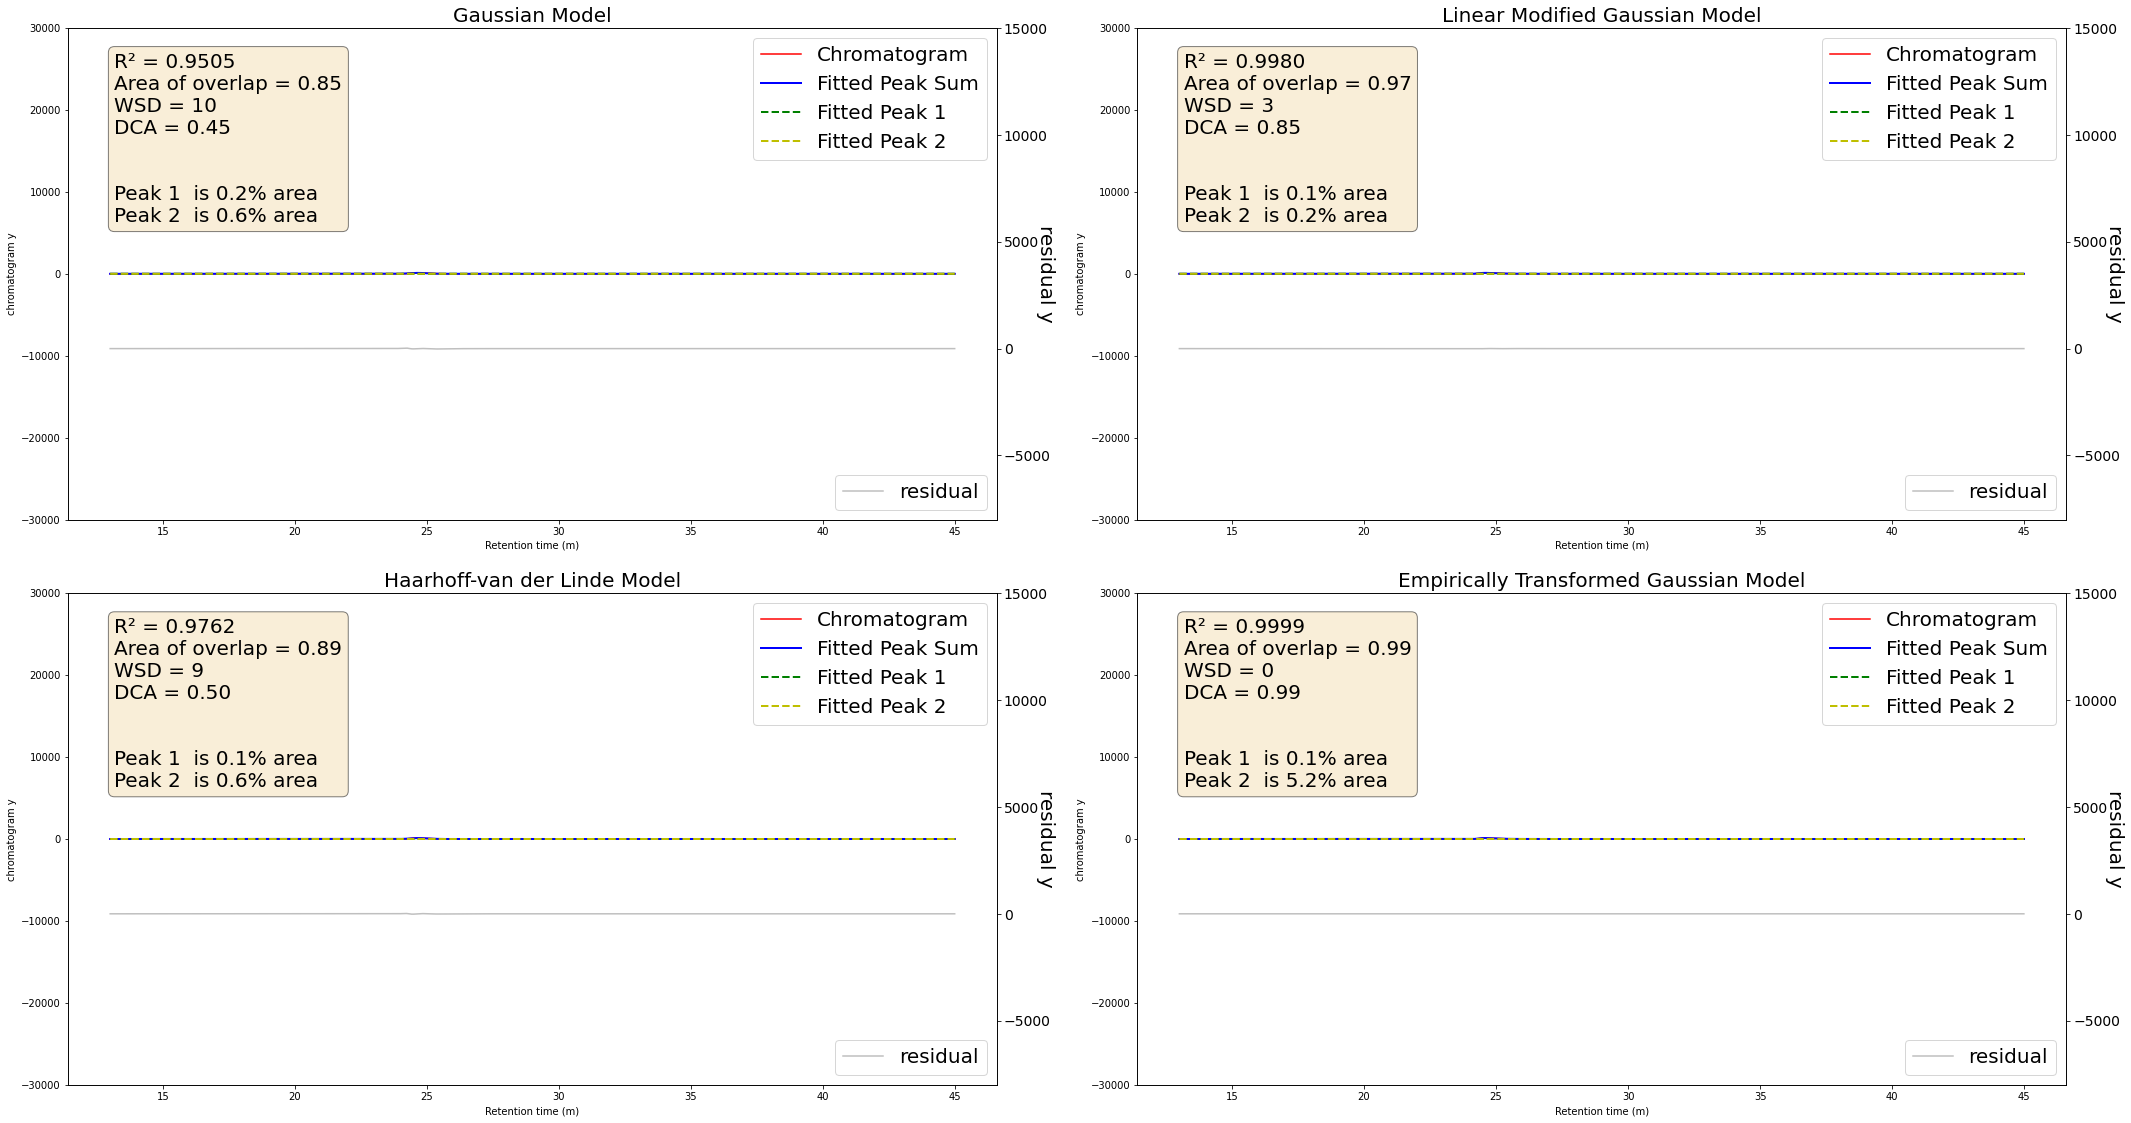

In [213]:
res_plots(x, y, sum_pk_fitted_ys, pk_fitted_ys, pk_fitted_resids, pk_R2s, pk_AOOs, pk_WSDs, pk_DCAs, pk_areas,pk_labels)